# `sf` Package Explorations

A small notebook to get more familiar with `sf` and how to use it to make drawing of confidence regions a lot easier/less painful

In [1]:
library(sf, warn.conflicts = FALSE)
library(sfheaders)
library(concaveman)
library(mvtnorm)
library(ks)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(ismev)
library(repr)

Linking to GEOS 3.10.2, GDAL 3.5.0, PROJ 9.0.0; sf_use_s2() is TRUE

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.



In [2]:
source('/global/u1/j/jbbutler/isolines_uq/scripts/R/utils.R')
source('/global/u1/j/jbbutler/isolines_uq/scripts/R/orig_isolines.R')


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




## Just Getting My Bearings

Getting `sf` to work with plotting the base confidence regions 

In [160]:
n <- 1000
lb <- -5
ub <- 5
p <- 0.05
alpha <- 0.05
grid <- expand.grid(X1 = seq(lb, ub, length.out = 200), X2 = seq(lb, ub, length.out = 200))
dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))

est_gsize <- 150
boot_gsize <- 150

B <- 200

xmin <- c(min(min(dat$X1), lb), min(min(dat$X2), lb))
xmax <- c(max(max(dat$X1), ub), max(max(dat$X2), ub))

In [161]:
surv_func <- kcde(dat, tail.flag = 'upper', gridsize = est_gsize, eval.points = grid, xmin = xmin, xmax = xmax)
hhat_vals <- -surv_func$estimate + p
deltamask <- abs(hhat_vals) <= (1/nrow(dat))^(1/3)

In [162]:
Zs <- rep(0, B)

for (i in 1:B) {

    boot_samp <- dat %>% sample_frac(1, replace = TRUE)
    boot_surv_func <- kcde(boot_samp, eval.points = grid, gridsize = boot_gsize,
                               tail.flag = 'upper', xmin = xmin, xmax = xmax)
    boot_hhat_vals <- -boot_surv_func$estimate + p
    Zs[i] <- max(abs((boot_hhat_vals - hhat_vals)[deltamask]))
}

bhat <- as.numeric(quantile(Zs, probs = 1 - alpha))
lower <- grid[hhat_vals > bhat,]
upper <- grid[hhat_vals >= -bhat,]

In [163]:
a <- sfg_polygon(obj = concaveman(as.matrix(upper), length_threshold = 0.6))

In [164]:
b <- sfg_polygon(obj = concaveman(as.matrix(lower), length_threshold = 0.6))

In [165]:
diff <- st_difference(a, b)

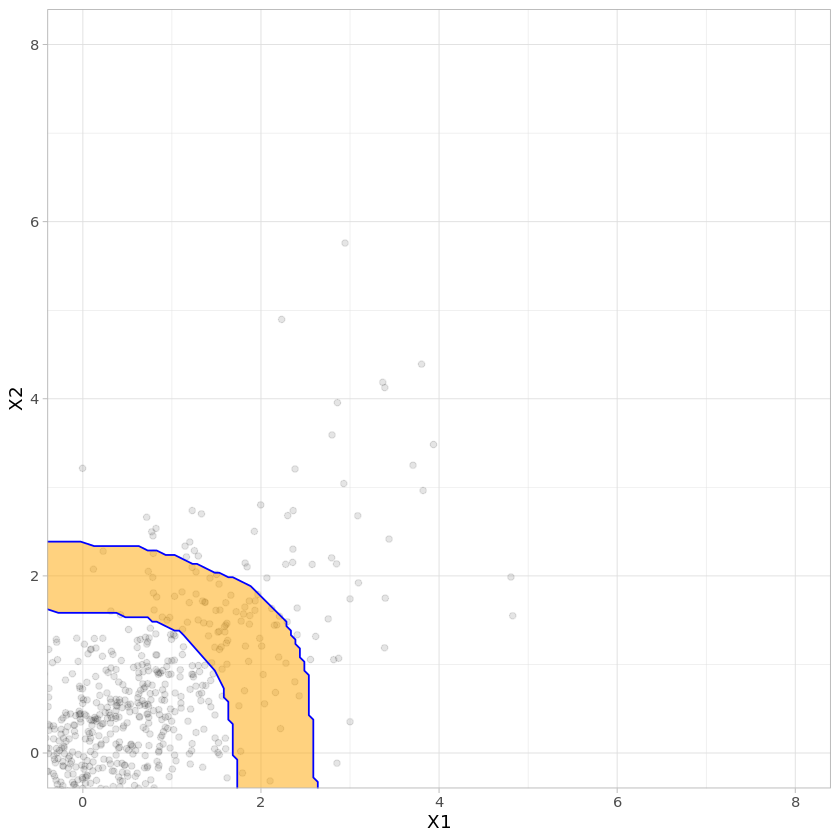

In [166]:
ggplot() + geom_point(data = dat, aes(x = X1, y = X2), alpha = 0.1) + 
geom_polygon(data = data.frame(diff[[1]]), aes(x = X1, y = X2), color = 'blue', fill = 'orange', alpha = 0.5) + 
coord_cartesian(ylim=c(0, 8), xlim = c(0, 8)) +
theme_light()



Getting `sf` to work with drawing the isolines and evaluating containment

In [143]:
isoline <- drawBivtIsoline(p = 0.05, grid = grid, tol = 0.0002)

In [171]:
iso <- sfg_multilinestring(isoline)

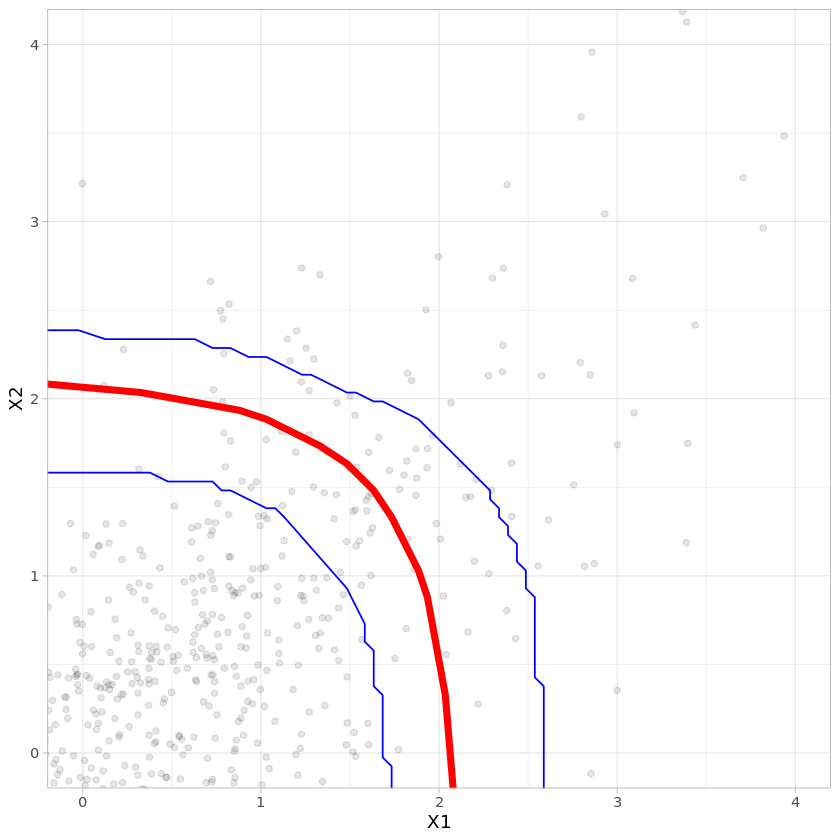

In [180]:
ggplot() + geom_point(data = dat, aes(x = X1, y = X2), alpha = 0.1) + 
geom_polygon(data = data.frame(diff[[1]]), aes(x = X1, y = X2), color = 'blue', fill = NA, alpha = 0.5) + 
geom_line(data = data.frame(as.matrix(iso)), aes(x = X1, y = X2), col = 'red', size = 2) +
coord_cartesian(ylim=c(0, 4), xlim = c(0, 4)) +
theme_light()

Note: I think this workflow is pretty good actually, things happen pretty quickly which is nice. Only things to consider:

1. How to choose the order of points to consider in drawing the polygon, so we obviate the need for `concaveman`
2. The snap grid mechanism for when we do the tail projections

## Applying it to Our Problem

### Plot multiple confidence regions on the same plot, with the base procedure.

In [382]:
plt <- ggplot()

n_iter <- 1
regions <- vector(mode = 'list', length = n_iter)

for (i in 1:n_iter) {

n <- 5000
lb <- -5
ub <- 5
p <- 0.05
alpha <- 0.05
grid <- expand.grid(X1 = seq(lb, ub, length.out = 200), X2 = seq(lb, ub, length.out = 200))
dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))

est_gsize <- 150
boot_gsize <- 150

B <- 200

xmin <- c(min(min(dat$X1), lb), min(min(dat$X2), lb))
xmax <- c(max(max(dat$X1), ub), max(max(dat$X2), ub))
    
surv_func <- kcde(dat, tail.flag = 'upper', gridsize = est_gsize, eval.points = grid, xmin = xmin, xmax = xmax)
hhat_vals <- -surv_func$estimate + p
deltamask <- abs(hhat_vals) <= (1/nrow(dat))^(1/3)
    
Zs <- rep(0, B)

for (j in 1:B) {

    boot_samp <- dat %>% sample_frac(1, replace = TRUE)
    boot_surv_func <- kcde(boot_samp, eval.points = grid, gridsize = boot_gsize,
                               tail.flag = 'upper', xmin = xmin, xmax = xmax)
    boot_hhat_vals <- -boot_surv_func$estimate + p
    Zs[j] <- max(abs((boot_hhat_vals - hhat_vals)[deltamask]))
}

bhat <- as.numeric(quantile(Zs, probs = 1 - alpha))
lower <- grid[hhat_vals > bhat,]
upper <- grid[hhat_vals >= -bhat,]
    
a <- sfg_polygon(obj = concaveman(as.matrix(upper), length_threshold = 0.6))
b <- sfg_polygon(obj = concaveman(as.matrix(lower), length_threshold = 0.6))
    
regions[[i]] <- sfg_polygon(obj = concaveman(as.matrix(setdiff(upper, lower)), length_threshold = 1))
plt <- plt + geom_polygon(data = data.frame(diff[[1]]), aes(x = X1, y = X2), color = 'blue', fill = 'gray', alpha = 0.1)
    
}

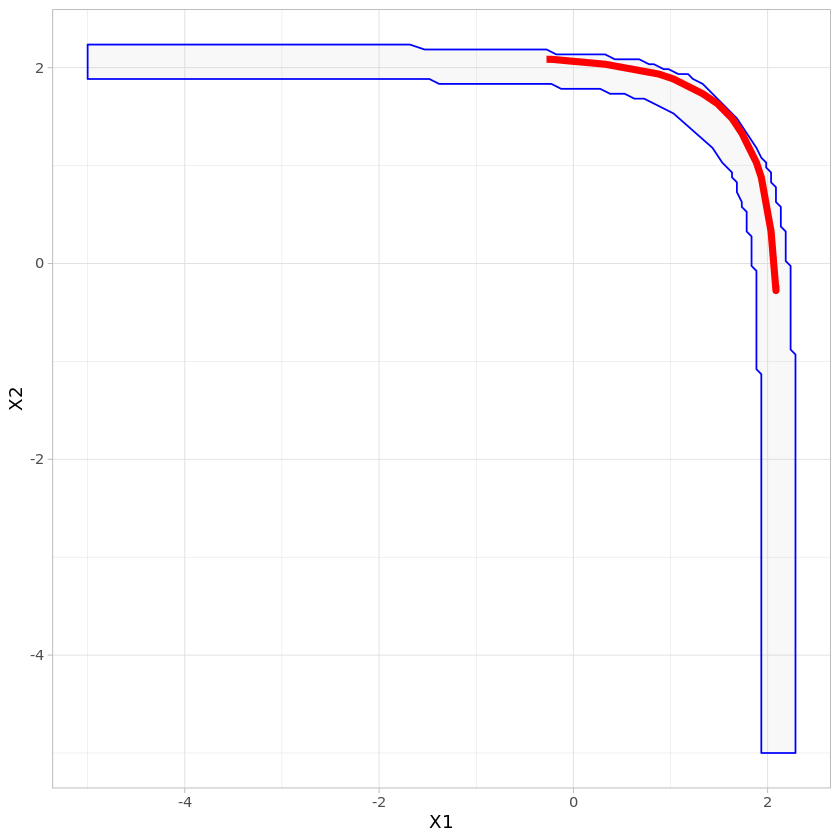

In [385]:
plt + geom_line(data = data.frame(as.matrix(iso)), aes(x = X1, y = X2), col = 'red', size = 2) + theme_light()

In [384]:
isoline <- drawBivtIsoline(p = 0.05, grid = grid, tol = 0.0002)
iso <- sfg_multilinestring(isoline)

### Now, try to build up the projection workflow.

In [3]:
n <- 15000
lb <- -5
ub <- 5
p <- 0.05
alpha <- 0.05
grid <- expand.grid(X1 = seq(lb, ub, length.out = 200), X2 = seq(lb, ub, length.out = 200))
dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))

est_gsize <- 500
boot_gsize <- 150

B <- 200

xmin <- c(min(min(dat$X1), lb), min(min(dat$X2), lb))
xmax <- c(max(max(dat$X1), ub), max(max(dat$X2), ub))
    
surv_func <- kcde(dat, tail.flag = 'upper', gridsize = est_gsize, eval.points = grid, xmin = xmin, xmax = xmax)
hhat_vals <- -surv_func$estimate + p
deltamask <- abs(hhat_vals) <= (1/nrow(dat))^(1/3)
    
Zs <- rep(0, B)

for (j in 1:B) {

    boot_samp <- dat %>% sample_frac(1, replace = TRUE)
    boot_surv_func <- kcde(boot_samp, eval.points = grid, gridsize = boot_gsize,
                               tail.flag = 'upper', xmin = xmin, xmax = xmax)
    boot_hhat_vals <- -boot_surv_func$estimate + p
    Zs[j] <- max(abs((boot_hhat_vals - hhat_vals)[deltamask]))
}

bhat <- as.numeric(quantile(Zs, probs = 1 - alpha))
lower <- grid[hhat_vals > bhat,]
upper <- grid[hhat_vals >= -bhat,]

In [4]:
base_region <- setdiff(upper, lower)
mar1Prop <- 0.03
mar2Prop <- 0.03
mar1Width <- 0.01
mar2Width <- 0.01

pproj <- 0.01

gpdOut1 <- gpd.fit(dat[,1], threshold = quantile(dat[,1], probs = 1 - mar1Prop), show = F)
gpdOut2 <- gpd.fit(dat[,2], threshold = quantile(dat[,2], probs = 1 - mar2Prop), show = F)
regionFrec <- cbind(-1/log(transMar(base_region[,1], dat, 1, mar1Prop, mar1Width, gpdOut1)),
                                                     -1/log(transMar(base_region[,2], dat, 2, mar2Prop, mar2Width, gpdOut2)))
projregionFrec <- regionFrec*(p/pproj)

projregionU <- exp(-1/projregionFrec)
projregion <- data.frame(cbind(invTransMar(projregionU[,1], dat, 1, mar1Prop, mar1Width, gpdOut1),
                                                invTransMar(projregionU[,2], dat, 2, mar2Prop, mar2Width, gpdOut2) ))

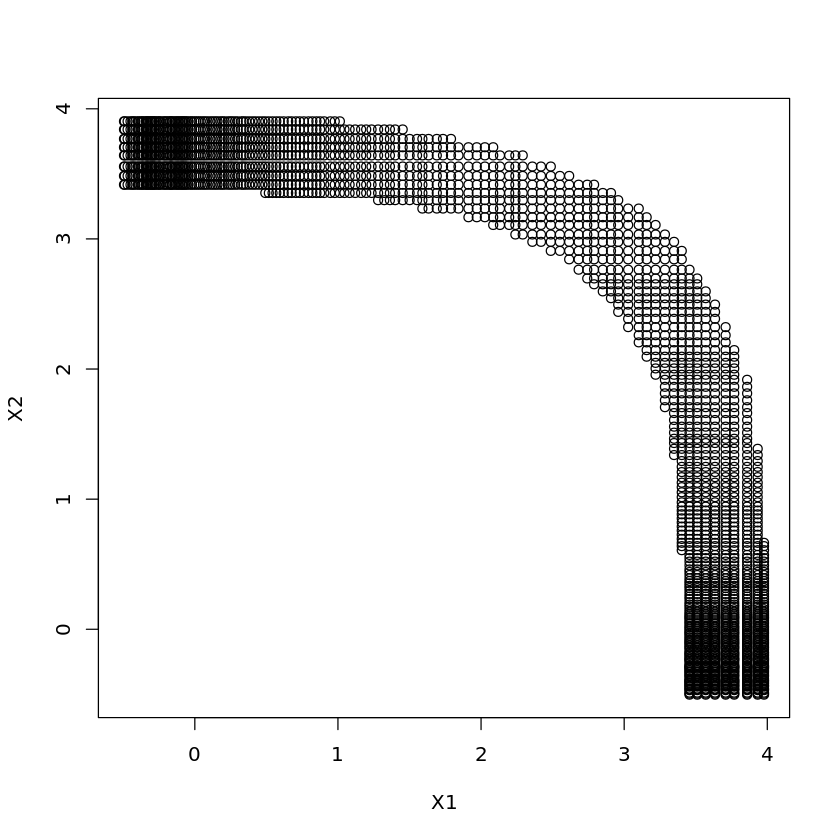

In [5]:
plot(projregion)

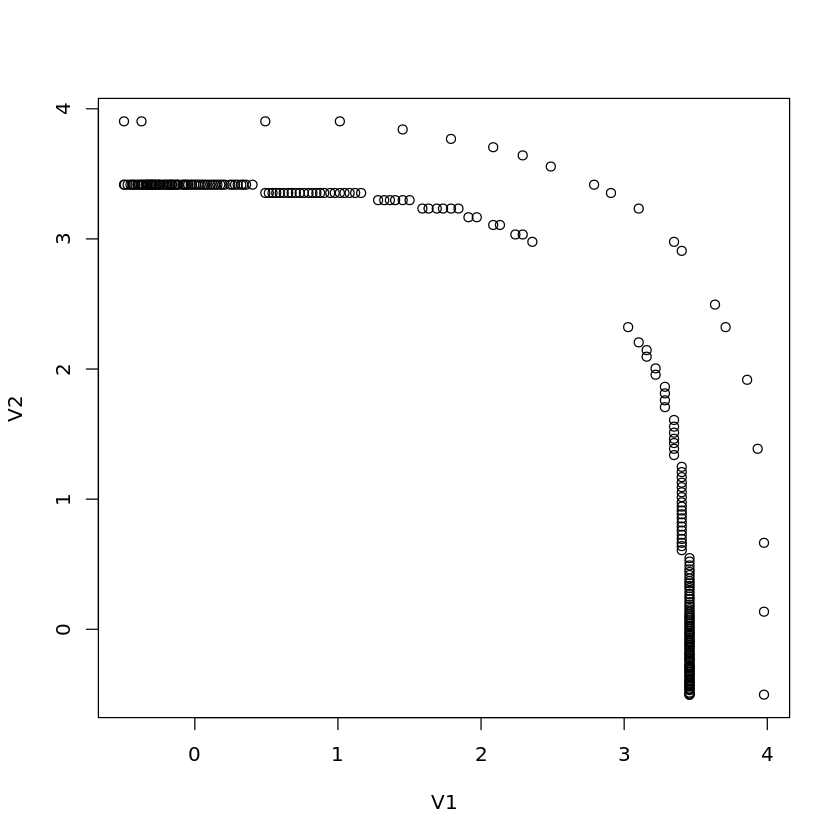

In [8]:
outline <- concaveman(as.matrix(projregion), length_threshold = 1)
plot(outline)

In [9]:
mins <- apply(projregion, 2, min)
lefts <- c(min((projregion %>% filter(X1 == mins[[1]]))$X2), max((projregion %>% filter(X1 == mins[[1]]))$X2))
rights <- c(min((projregion %>% filter(X2 == mins[[2]]))$X1), max((projregion %>% filter(X2 == mins[[2]]))$X1))
mins <- ceiling(mins*10^(4))/(10^4)
left_topoff <- data.frame(X1 = c(rep(lb, 2), rep(mins[[1]], 2)), X2 = c(lefts, lefts[2], lefts[1]))
right_topoff <- data.frame(X1 = c(rights, rights[2], rights[1]), X2 = c(rep(lb, 2), rep(mins[[2]], 2)))


outline <- sfg_polygon(outline)
left_topoff <- sfg_polygon(left_topoff)
right_topoff <- sfg_polygon(right_topoff)
outline_topoff <- st_union(st_union(outline, left_topoff), right_topoff)

X1        X2 
-0.494402 -0.497328

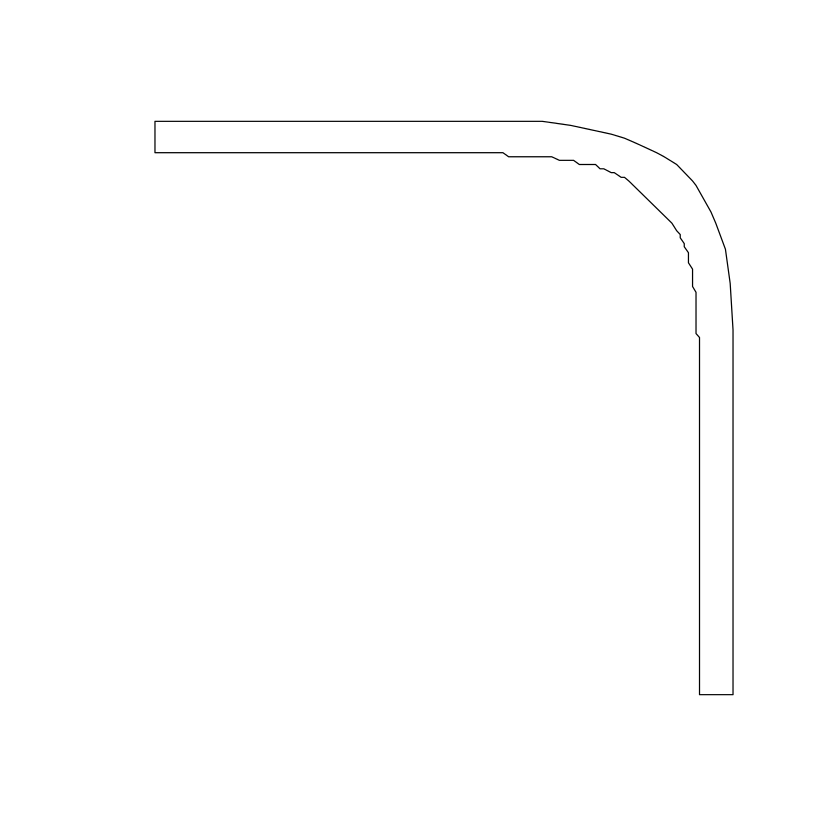

In [10]:
plot(outline_topoff)

In [11]:
plt <- ggplot() + geom_polygon(data = data.frame(outline_topoff[[1]]), aes(x = X1, y = X2), color = 'blue', fill = 'gray', alpha = 0.2) +
    #geom_polygon(data = data.frame(outline_topoff[[2]]), aes(x = X1, y = X2), color = 'blue', fill = 'gray', alpha = 0.2) +
    #geom_polygon(data = data.frame(outline_topoff[[3]]), aes(x = X1, y = X2), color = 'blue', fill = 'gray', alpha = 0.2) +
    theme_minimal()




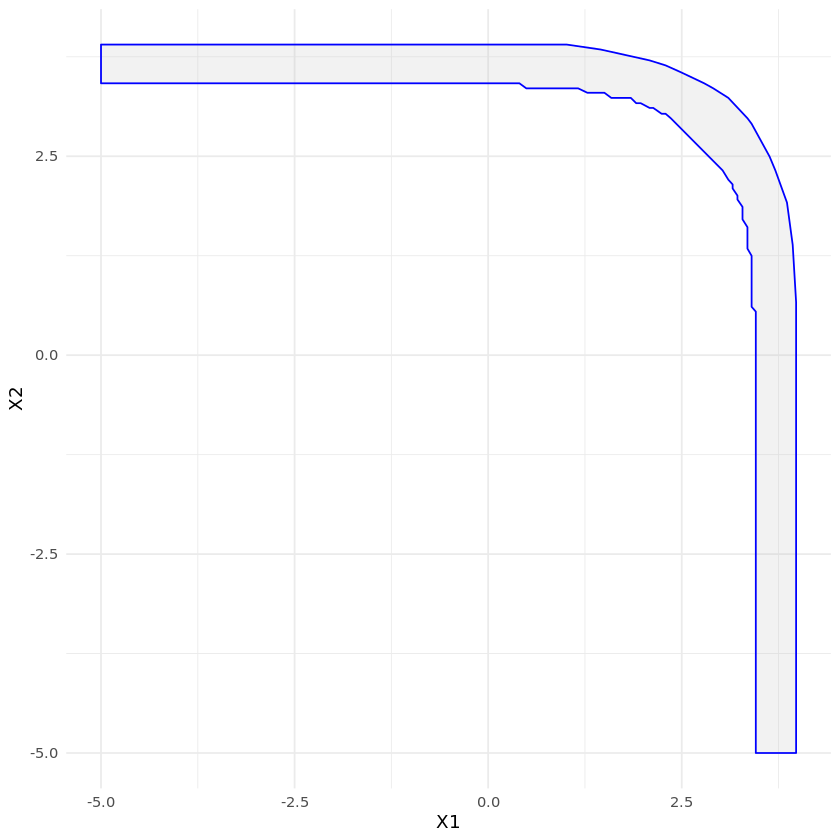

In [12]:
plt

In [13]:
st_area(outline_topoff)

[1] 8.576971

In [14]:
isoline <- drawBivtIsoline(p = 0.01, grid = grid, tol = 0.0002)
iso <- sfg_multilinestring(isoline)

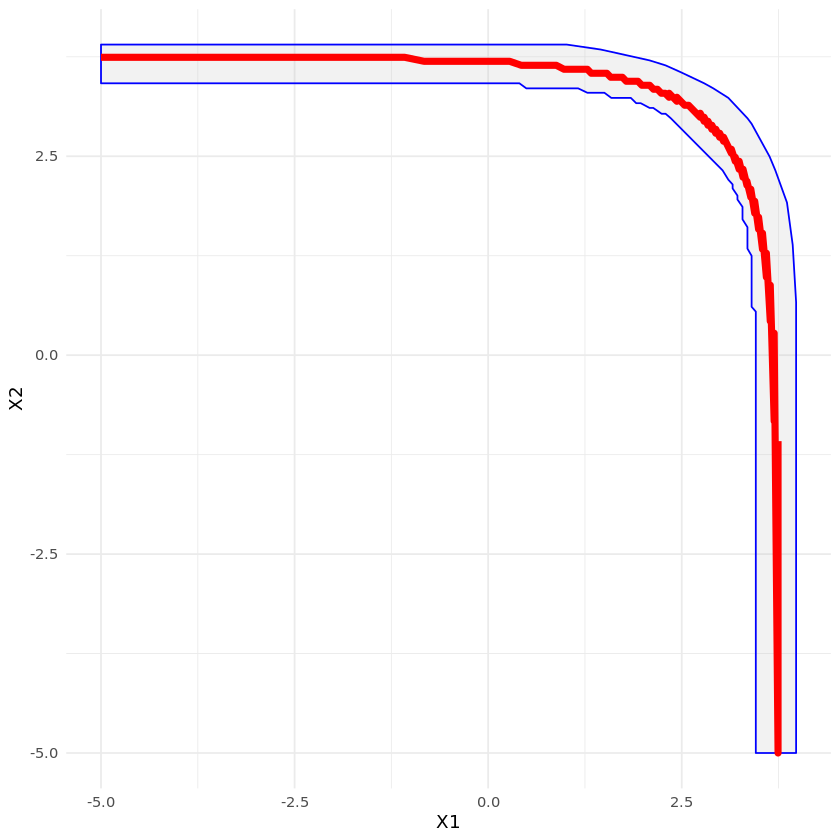

In [15]:
plt + geom_line(data = data.frame(as.matrix(iso)), aes(x = X1, y = X2), col = 'red', size = 2)

In [16]:
as.logical(st_contains(outline_topoff, iso, sparse = FALSE))

[1] TRUE

# Kinks to Work Out as of 9/9

1. Coordinate system of the `sfg` objects for area calculations
2. Why region stops drawing abruptly (doesn't complete the full grid)
3. Obviating the need for concaveman, ok if not?

Answers:

1. I don't think the CRS is something we have to worry about, that's just if we have longitudes/latitudes or data in particular units. I think if NA, it shouldn't matter. Even if the area looks crazy after projection, we're still just extracting the boundary and creating a polygon with those remaining points. So across many different samples, we will just have polygons for which we want to compute the area, so it will likely be uniformly computed (probably isn't making reference to some underlying coordinate system, especially because when given a polygon, there is no information about the underlying coordinate system)

2. I think there was some rounding issue that caused the vertices to be smaller than expected, so there was no overlap. Also, I think when evaluating `st_union`, it only considers the first four decimal places (so even though I definitely had overlap at later decimal places, it did not consider that as overlap until the fourth). So, my solution is to just round to the nearest 4th decimal place. I think it also might be some floating point error thing but idk. Rounding up to the nearest 4th decimal place seems to solve my issues.

3. I think concaveman is here to stay, at least for now (can make methodological changes later, though). However, given the issues with how large the region is drawing, I think it's worth considering how to control the order in which points are drawn.

# Then

Implement the data-driven beta_n choice mechanism